In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.cm as cm

import sys
import os
import inflect
import numpy as np
from tqdm import tqdm
import torch
import IPython.display as ipd
sys.path.append('../')
sys.path.append('../synthesis/')

from dataset.transcribe import transcribe
from synthesis.synthesize import load_model, load_waveglow, text_to_sequence
from preprocessing.clean_text import clean_text

In [2]:
text = "There is a way to measure the acute emotional intelligence that has never gone out of style."
model_path = "checkpoint_459000"
waveglow_path = "waveglow_256channels_universal_v5.pt"

# Alignment

In [3]:
inflect_engine = inflect.engine()
model = load_model(model_path)
text = clean_text(text, inflect_engine)
sequence = text_to_sequence(text)
_, mel_outputs_postnet, _, alignments = model.inference(sequence)

(92, 497)


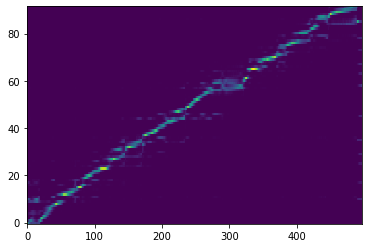

In [4]:
data = alignments.float().data.cpu().numpy()[0].T
y_length, x_length = data.shape
plt.imshow(data, aspect='auto', origin='lower', interpolation='none')
print(data.shape)

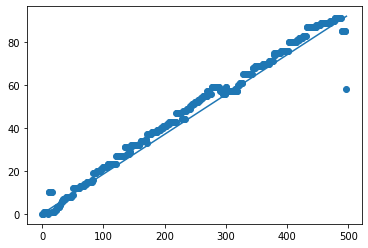

In [5]:
points = []

for i in range(0,x_length):
    current = list(data[:,i])
    points.append(current.index(max(current)))

plt.scatter(range(0,x_length), points)
plt.plot((0,x_length),(0,y_length))

# Cut trailing points

In [6]:
def get_highest_confidence_points(data):
    points = []

    for i in range(0,data.shape[1]):
        current = list(data[:,i])
        points.append(current.index(max(current)))
    
    return points

In [7]:
def cut_trailing_points(data):
    highest_point = 0
    highest_point_index = 0
    for i in range(0,data.shape[1]):
        current = list(data[:,i])
        point = current.index(max(current))
        if point > highest_point:
            highest_point = point
            highest_point_index = i
            
    return data[:,:highest_point_index]

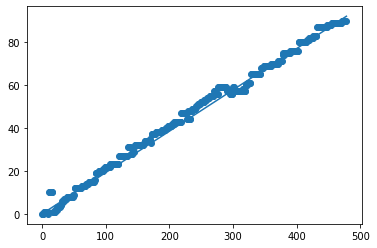

In [8]:
data = cut_trailing_points(data)
y_length, x_length = data.shape
points = get_highest_confidence_points(data)

plt.scatter(range(0,x_length), points)
plt.plot((0,x_length),(0,y_length))

# Alignment Scoring

In [9]:
def plot_scores(scores, points, x_length):
    colours = []
    for i in range(0, x_length):
        region_score = scores[i]
        red = 1-region_score
        colours.append(red)

    plt.scatter(range(0,x_length), points, c=[(red,0,1-red) for red in colours])

In [10]:
def calculate_alignment_scores(data, sample_padding=2):
    y_length, x_length = data.shape
    grad = y_length/x_length
    scores = []

    for x in range(0,x_length):
        y = int(x * grad)
        min_index = max(0, y-sample_padding)
        max_index = min(y_length, y+sample_padding)

        score = sum([data[i,x] for i in range(min_index, max_index)])
        scores.append(score)

    return scores

Overall alignment score: 0.3876011150526583
Best: 0.9937464000540785 Worst 0.00020468094953685068


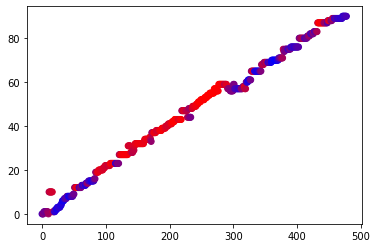

In [11]:
scores = calculate_alignment_scores(data)
print("Overall alignment score:", sum(scores)/len(scores))
print("Best:", max(scores), "Worst", min(scores))
plot_scores(scores, points, x_length)

# Confidence scoring

In [12]:
def calculate_confidence_scores(data):
    y_length, x_length = data.shape
    return [max(data[:,i]) for i in range(x_length)]

Overall confidence score: 0.4563400856994685
Best: 0.87784207 Worst 0.1754935


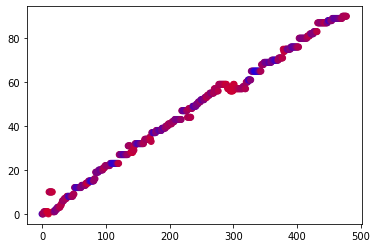

In [13]:
scores = calculate_confidence_scores(data)
print("Overall confidence score:", sum(scores)/len(scores))
print("Best:", max(scores), "Worst", min(scores))
plot_scores(scores, points, x_length)

# Gap scoring

In [14]:
def calculate_gap_scores(data):
    distances = []
    points = get_highest_confidence_points(data) 
    for i in range(0, len(points)-1):
        distances.append(abs(points[i] - points[i+1]))
        
    distances.append(0)
    
    max_distance = max(distances)
    return [1-(dist/max_distance) for dist in distances]

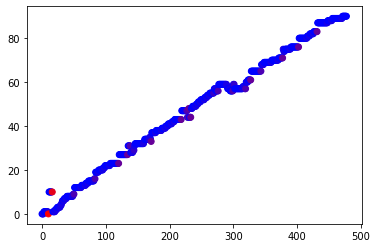

In [15]:
scores = calculate_gap_scores(data)
plot_scores(scores, points, x_length)

# Score checkpoints

In [16]:
checkpoints_directory = "../../tacotron2/outdir"

In [17]:
num_checkpoints = len([f for f in os.listdir(checkpoints_directory) if os.path.isfile(os.path.join(checkpoints_directory,f))])
print(num_checkpoints)
alignment_scores = []
confidence_scores = []
gap_scores = []

for checkpoint in tqdm(range(1000, num_checkpoints*1000, 1000)):
    model = load_model(os.path.join(checkpoints_directory, f"checkpoint_{checkpoint}"))
    _, _, _, alignments = model.inference(sequence)
    data = alignments.float().data.cpu().numpy()[0].T
    cut_data = cut_trailing_points(data)
    if cut_data.shape[1] > 0:
        data = cut_data
    
    alignment = calculate_alignment_scores(data)
    confidence = calculate_confidence_scores(data)
    gap = calculate_gap_scores(data)
    alignment_scores.append(sum(alignment)/len(alignment))
    confidence_scores.append(sum(confidence)/len(confidence))
    gap_scores.append(sum(gap)/len(gap))

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../../tacotron2/outdir'

In [ ]:
plt.scatter(range(len(alignment_scores)), alignment_scores, color="red")
plt.scatter(range(len(alignment_scores)), confidence_scores, color="blue")
plt.scatter(range(len(gap_scores)), gap_scores, color="green")

In [ ]:
final = []
for i in range(len(gap_scores)):
    print(gap_scores[i], confidence_scores[i])
    final.append(gap_scores[i]*confidence_scores[i])

In [ ]:
plt.scatter(range(len(gap_scores)), final, color="green")

# Replacing words

In [18]:
waveglow = load_waveglow("waveglow_256channels_universal_v5.pt")

D:\anaconda3\envs\dataset\lib\site-packages\torch\serialization.py:658: SourceChangeWarning: source code of class 'glow.WaveGlow' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
D:\anaconda3\envs\dataset\lib\site-packages\torch\serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
D:\anaconda3\envs\dataset\lib\site-packages\torch\serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or

In [19]:
text = clean_text(text, inflect_engine)
sequence = text_to_sequence(text)
_, mel_outputs_postnet, _, alignments = model.inference(sequence)

0.45342614066330983

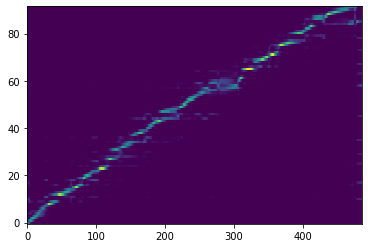

In [20]:
data = alignments.float().data.cpu().numpy()[0].T
plt.imshow(data, aspect='auto', origin='lower', interpolation='none')
scores = calculate_confidence_scores(data)
sum(scores)/len(scores)

In [21]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\benan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            if "_" not in l.name():
                synonyms.add(l.name().lower())
    synonyms.discard(word)
    return synonyms

In [23]:
def produce_audio(text): 
    sequence = text_to_sequence(text)
    _, mel_outputs_postnet, _, _ = model.inference(sequence)

    with torch.no_grad():
        audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
        audio = audio[0].data.cpu().numpy()

    return audio

In [24]:
text = "There is a way to measure the acute emotional intelligence that has never gone out of style."
text = clean_text(text, inflect_engine)
print(text)
audio = produce_audio(text)
ipd.Audio(audio, rate=22050)

there is a way to measure the acute emotional intelligence that has never gone out of style.


In [25]:
import scipy.io.wavfile
scipy.io.wavfile.write('temp.wav',22050,audio)
results = transcribe("temp.wav")

Using cache found in C:\Users\benan/.cache\torch\hub\snakers4_silero-models_master
D:\anaconda3\envs\dataset\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
D:\anaconda3\envs\dataset\lib\site-packages\torchaudio\backend\utils.py:63: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(
D:\anaconda3\envs\dataset\lib\site-packages\torch\nn\modules\module.py:727: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return

In [31]:
def evalulate_audio(audio):
    scipy.io.wavfile.write('temp.wav',22050,audio)
    results = transcribe("temp.wav")
    original_words = text.split(" ")
    produced_words = results.split(" ")
    return set(original_words) - set(produced_words)

In [32]:
scipy.io.wavfile.write('temp.wav',22050,audio)
results = transcribe("temp.wav")
print(text)
print(results)

there is a way to measure the acute emotional intelligence that has never gone out of style.
there is a way to mure v octoroional intelligence it so has never gone out plse


In [33]:
def find_replacement_word(text, word):
    synonyms = get_synonyms(word)
    print(word, synonyms)
    if synonyms: 
        for synonym in synonyms:
            new_text = text.replace(word, synonym)
            new_audio = produce_audio(new_text)
            missed_words = evalulate_audio(new_audio)
            if synonym not in missed_words:
                return new_text
    else:
        return text

In [35]:
words_not_produced_correctly = evalulate_audio(audio)
print(words_not_produced_correctly)
for word in words_not_produced_correctly:
    new_text = find_replacement_word(text, word)

{'the', 'that', 'of', 'measure', 'acute', 'style.', 'emotional'}
the set()
there is a way to measure the acute emotional intelligence that has never gone out of style.
that set()
there is a way to measure the acute emotional intelligence that has never gone out of style.
of set()
there is a way to measure the acute emotional intelligence that has never gone out of style.
measure {'metre', 'appraise', 'amount', 'mensuration', 'beat', 'assess', 'touchstone', 'standard', 'meter', 'cadence', 'measurement', 'bill', 'quantify', 'value', 'valuate', 'measuring', 'mensurate', 'bar', 'quantity', 'evaluate', 'step', 'criterion'}
there is a way to metre the acute emotional intelligence that has never gone out of style.
acute {'discriminating', 'knifelike', 'keen', 'incisive', 'sharp', 'penetrating', 'ague', 'penetrative', 'needlelike', 'acuate', 'intense', 'piercing'}
there is a way to measure the discriminating emotional intelligence that has never gone out of style.
style. set()
there is a way t

In [36]:
audio = produce_audio(new_text)
ipd.Audio(audio, rate=22050)

# Select best inference

best_score = 0
best = []
worst_score = 1
worst = []

for i in range(50):
    _, mel_outputs_postnet, _, alignments = model.inference(sequence)
    data = alignments.float().data.cpu().numpy()[0].T
    
    scores = calculate_scores(data)
    score = sum(scores)/len(scores)
    
    if score > best_score:
        best_score = score
        best = [mel_outputs_postnet, data]
    
    if score < worst_score:
        worst_score = score
        worst = [mel_outputs_postnet, data]
    
    print(score)

print(best_score)
with torch.no_grad():
    audio = waveglow.infer(best[0], sigma=0.66)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

plt.imshow(best[1], aspect='auto', origin='bottom', interpolation='none')

print(worst_score)
with torch.no_grad():
    audio = waveglow.infer(worst[0], sigma=0.66)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

plt.imshow(worst[1], aspect='auto', origin='bottom', interpolation='none')